In [1]:
import numpy as np
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

The code below loads each relevant csv file into a pandas DataFrame. Since some of the URL's contained in the data files have white space, the `.strip()` function is used to remove leading/lagging spaces so that they can be directly compared across files to look for corruption later on, as well as saved into the SQL database such that functional dependencies are satisfied.

In [2]:
# Products URL should be considered "gold standard"
# strip leading/lagging whitespace
products_df = pd.read_csv('../data/products.csv')
for col_name in products_df.columns:
    stripped_col = products_df[col_name].str.strip().values
    products_df[col_name]  = stripped_col

products_df = products_df.drop_duplicates()
products_df.reset_index(drop=True, inplace=True)

product_categories_df = pd.read_csv('../data/product_categories.csv')
for col_name in product_categories_df.columns:
    stripped_col = product_categories_df[col_name].str.strip().values
    product_categories_df[col_name]  = stripped_col

log_df = pd.read_csv('../data/log2.csv',
                     names=['sentiment', 'publication_URL', 'product_URL',
                     'clickORnot', 'gender', 'age_group'])
for col_name in log_df.columns:
    if not col_name == 'clickORnot':
        stripped_col = log_df[col_name].str.strip().values
        log_df[col_name]  = stripped_col

In [3]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",   #REPLACE THIS WITH THE PASSWORD YOU SET
  database="data1050_project"
)
 
print(mydb)
 
if mydb.is_connected():
    print("CONNECTION SUCCESSFUL")

CONNECTION SUCCESSFUL


The drop table celll below is necessary if this notebook is used to recreate the SQL database from scratch.

In [8]:
mycursor = mydb.cursor()
mycursor.execute("DROP TABLE products;")
mycursor.execute("DROP TABLE product_type_pubURLs;")
mycursor.execute("DROP TABLE product_categories;")


Below the `product` and `product_categories` tables are created with the functional dependency:

`products.product_type` -> `product_categories.product`

In [9]:
#create a table
mycursor.execute("CREATE TABLE product_categories (product VARCHAR(255), category VARCHAR(255),"
                 "PRIMARY KEY (product));")

mycursor.execute("CREATE TABLE products (product VARCHAR(255), product_URL VARCHAR(255), "
                 "product_type VARCHAR(255), PRIMARY KEY (product),"
                 "FOREIGN KEY (product_type) REFERENCES product_categories (product));")

Finally we iterate over the rows of both DataFrames to load the data into the appropriate SQL table.

In [10]:
for i,product_categories_row in product_categories_df.iterrows():
        sql = "INSERT INTO product_categories VALUES (%s,%s)"
        mycursor.execute(sql, tuple(product_categories_row))
        print("Record inserted")
        # the connection is not autocommitted by default, so we 
        # must commit to save our changes
        mydb.commit()

Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted


In [11]:
for i,products_row in products_df.iterrows():
        sql = "INSERT INTO products VALUES (%s,%s,%s)"
        mycursor.execute(sql, tuple(products_row))
        print("Record inserted")
        # the connection is not autocommitted by default, so we 
        # must commit to save our changes
        mydb.commit()

Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted


### Question 1
*Some of the Product_URLs in the log file might have been corrupted. Write a Python (or PySpark) procedure to determine which Product_URLs are corrupted. Let us assume that if a Product_url in the log file doesn’t occur in the products table, it is regarded as corrupted. Using this procedure identify and list the corrupted URLs. (10)*

The code below uses the simple list matching function `np.in1d()` to quickly identify which URLs in the log file are not present in the products file. This creates the boolean array `url_mask` which is subsequently used to create DataFrame `corrupt_df` that exclusively contains corrupted product URLs.

In [12]:
product_urls = products_df['product_URL']
log_urls = log_df['product_URL']

# Check which elements of log_urls are NOT an exact match in product_urls
url_mask = ~np.in1d(log_urls, product_urls)
corrupt_df = log_df[url_mask]
corrupt_df

,sentiment,publication_URL,product_URL,clickORnot,gender,age_group
83,negative,https://www.cbsnews.com/,https://haier.com/refrigermtors,0,female,young
109,neutral,https://mashable.com/,https://sony.comftelevisions,1,female,juvenile
123,negative,https://www.thedailybeast.com/,https://lg.com/gashers,0,female,middle-age
171,neutral,https://www.cnn.com/,https://leks.com/jeans,0,female,senior
203,neutral,https://www.nytimes.com/,https://InstantPot.con/cookers,1,female,young
...,...,...,...,...,...,...
9729,neutral,https://www.usnews.com/,http://nejoK.co/blenders,0,male,senior
9773,negative,https://www.nbcnews.com/,https://maytag.cpm/washers,1,male,middle-age
9845,positive,https://www.foxnews.com/,https://guessmcom/perfumes,1,female,middle-age
9881,neutral,https://www.usnews.com/,https://samsuag.com/televisions,0,female,young


### Question 2
*For each corrupted URL what will you do with it? Don’t assume that for each corrupted URL the correct approach is to delete that log entry. What if the URL contained ‘.cam’ instead of ‘.com’ but otherwise corresponded with a URL in the ‘products’ table? In that case the proper approach would be to correct the URL. In other cases, the URL might be so corrupted that the best approach would be to delete that log entry (the entire row). Describe your approach to dealing with corrupted URLs. That is, describe your approach to determining that a URL is too corrupted to be rescued. It must describe a) a procedure for determining the degree to which the URL is corrupted, b) a threshold for determining in terms of this degree of corruption whether it can be corrected, and c) for those which can be corrected, identifying its corrected form. For extra credit implement this in a Python (or PySpark) program. (25 + 20 points for extra-credit)*

For the corrupted URLs, we are going to assume that there is one intended URL in 'products.csv'. To pair corrupted URLs to real URLs, we will utilize the "edit distance" to identify how many insertions, deletions, or character changes are necessary to transform a corrupted URL into one of the true URLs. Formally this is referred to a Levenshtein distance  

Assuming that it is unlikely that a single character is corrupted, I will set a edit distance threshold of 3 such that any URLs that are 3 edits or greater away from any of the ground truth URLs will be considered "too corrupted". Additionally, if any corrupted URLs have the same edit distance from 2 or more ground truth URLs they will not be included in the database.

In [13]:
# Utilizing natural language toolkit implementation: https://www.nltk.org/api/nltk.metrics.distance.html
from nltk.metrics.distance import edit_distance
from functools import partial

dist_dict = dict()
for true_url in product_urls:
    # Create function to calculate edit distance to true URL
    dist_func = partial(edit_distance, s2=true_url)
    dist_dict[true_url] = corrupt_df['product_URL'].map(dist_func)

dist_df = pd.DataFrame(dist_dict).set_index(corrupt_df['product_URL']).transpose()
dist_df
    

product_URL,https://haier.com/refrigermtors,https://sony.comftelevisions,https://lg.com/gashers,https://leks.com/jeans,https://InstantPot.con/cookers,https://lenova.comslaptops,https://broyhill.cvm/recliners,https://apple.cfm/ipads,https://soundwavemai/speakers,https://haieq.com/refrigerators,...,https://basilbasel.io/perfunes,https://cougar.co/jeaas,https://levia.com/jeans,https://Ikea.lom/sofas,https://apple.com/iqads,http://nejoK.co/blenders,https://maytag.cpm/washers,https://guessmcom/perfumes,https://samsuag.com/televisions,https://InstantPotycom/cookers
https://vitamix.com/blenders,16,16,12,13,14,14,13,14,16,16,...,17,14,12,14,13,9,12,15,15,14
https://lenova.com/laptops,16,14,10,10,16,1,17,12,17,16,...,18,13,9,12,12,12,12,14,14,16
https://InstantPot.com/cookers,19,19,14,16,1,16,16,16,16,19,...,18,16,15,14,15,15,13,18,18,1
http://nemoK.co/blenders,17,16,12,12,15,12,16,14,16,17,...,19,13,12,15,13,1,14,15,16,16
https://HamiltonBeach/blenders,19,19,16,18,18,17,17,16,16,19,...,17,18,18,19,16,12,16,20,19,18
https://Lavazza.com/coffee,17,19,13,13,14,14,16,13,18,17,...,16,14,11,11,12,16,13,14,17,14
https://Starbucks.com/coffee,19,20,15,13,14,17,17,15,20,19,...,17,15,15,14,14,18,15,14,18,14
https://centrum.com/vitamins,16,15,14,11,16,13,16,13,17,17,...,19,13,11,14,12,15,14,14,15,16
https://NordicTrack.com/treadmills,19,18,19,18,21,19,18,19,20,21,...,20,17,16,19,18,20,19,20,17,21
https://NordicTrack.com/rowers,18,18,15,16,15,17,16,17,18,19,...,18,15,14,15,16,18,15,18,19,15


In [14]:
dist_threshold = 3

# Make list of corrupted URLs that can be corrected
fixed_mask = list()
fixed_urls = list()
for col_idx in range(len(dist_df.columns)):
    url_distances = dist_df.iloc[:, col_idx]
    edit_counts = url_distances.value_counts()
    min_dist = edit_counts.min()

    if (min_dist > dist_threshold) or edit_counts[min_dist] > 1:
        fixed_mask.append(False)
    else:
        min_idx = np.where(url_distances.values == min_dist)
        assert len(min_idx) == 1
        
        fixed_mask.append(True)
        fixed_urls.append(product_urls[min_idx[0][0]])
        print(f'edit dist={min_dist}; {dist_df.columns[col_idx]}, {fixed_urls[-1]}')



edit dist=1; https://haier.com/refrigermtors, https://haier.com/refrigerators
edit dist=1; https://sony.comftelevisions, https://sony.com/televisions
edit dist=1; https://lg.com/gashers, https://lg.com/washers
edit dist=1; https://leks.com/jeans, https://lees.com/jeans
edit dist=1; https://InstantPot.con/cookers, https://InstantPot.com/cookers
edit dist=1; https://lenova.comslaptops, https://lenova.com/laptops
edit dist=1; https://broyhill.cvm/recliners, https://broyhill.com/recliners
edit dist=1; https://apple.cfm/ipads, https://apple.com/ipads
edit dist=1; https://soundwavemai/speakers, https://soundwave.ai/speakers
edit dist=1; https://haieq.com/refrigerators, https://haier.com/refrigerators
edit dist=1; https://reminxton.com/shavers, https://remington.com/shavers
edit dist=1; https://kaxi.com/handbags, https://kaai.com/handbags
edit dist=1; https://delk.com/computers, https://dell.com/computers
edit dist=1; https://apple.com/tomputers, https://apple.com/computers
edit dist=1; https

In [15]:
print(f'num corrupted: {len(corrupt_df)}; num recovered: {len(fixed_urls)}')

num corrupted: 216; num recovered: 216


As we can see above, our algorithm was able to identify a matching URL for every corrupted URL. Therefore we can simply substitute the "fixed" URLs into the 'product_URL' field of `log_df`

In [16]:
log_urls_fixed = log_df['product_URL'].values
log_urls_fixed[url_mask] = fixed_urls

# Store fixed URLs in new columns alongside boolean indicating which rows were fixed
log_df['product_URL'] = log_urls_fixed
log_df['url_fixed'] = url_mask

### Question 3
*For each product, compute all the Publication_URLs containing an ad for that product. (Don’t just give the results. Show all the work by which you got those results. This applies to all the questions below.) (10)*

To gather all the publication URLs, we need to combine information from `log2.csv` and `products.csv`. Since 'publication_URL' is present in both tables. To do this, we will first define a simple mapping function `get_pub_url()` that 1) looks up the product URL associated with a specific product name, and 2) use that product_URL to find and return all the publication URLs in the log file.

In [17]:
def get_pub_url(product_name, log_df=log_df, products_df=products_df):
    product_url = products_df.loc[products_df['product'] == product_name]['product_URL'].values
    assert len(product_url) == 1

    publication_URLs = log_df.loc[log_df['product_URL'] == product_url[0]]['publication_URL'].values
    publication_URLs = np.unique(publication_URLs)
    return publication_URLs


In [18]:
product_pub_urls = products_df['product'].map(get_pub_url)
products_df['product_pub_URLs'] = product_pub_urls
products_df

,product,product_URL,product_type,product_pub_URLs
0,Vitamix blender,https://vitamix.com/blenders,blender,"[https://abcnews.go.com/, https://nypost.com/,..."
1,Lenova laptop,https://lenova.com/laptops,computer,"[https://abcnews.go.com/, https://techcrunch.c..."
2,InstantPot pressure cooker,https://InstantPot.com/cookers,pressure cooker,"[https://abcnews.go.com/, https://mashable.com..."
3,NemoK blender,http://nemoK.co/blenders,blender,"[https://abcnews.go.com/, https://mashable.com..."
4,Hamilton Beach blender,https://HamiltonBeach/blenders,blender,"[https://nypost.com/, https://techcrunch.com/,..."
5,Lavazza Coffee,https://Lavazza.com/coffee,coffee,"[https://nypost.com/, https://www.boston.com, ..."
6,Starbucks Coffee,https://Starbucks.com/coffee,coffee,"[https://mashable.com/, https://nypost.com/, h..."
7,Centrum MultiVitamins,https://centrum.com/vitamins,vitamin,"[https://mashable.com/, https://techcrunch.com..."
8,NordicTrack treadmill,https://NordicTrack.com/treadmills,treadmill,"[https://mashable.com/, https://techcrunch.com..."
9,NordicTrack rower,https://NordicTrack.com/rowers,rowing machine,"[https://abcnews.go.com/, https://mashable.com..."


### Question 4
*For each product type, compute all the Publication_URLs containing an ad for that product type. Your solution must be scalable. That is, it should work well even if there are hundreds of products in each product_type and there are hundreds of product_types. (Hint: To make it scalable you should consider using a Python or PySpark script instead of a SQL query.) (20)*

In the previous question we calculated all the publication URLs for each product and stored it under the column `product_pub_URLs`. Since a product is associated with a specific product, we can utilize the group by functionality in pandas to aggregate the URLs of rows of a matching `product_type` into the same list, concatenating the list of lists of type specific URLs, and finally removing redunant entries using `np.unique()`.

In [19]:
type_pub_urls = products_df.groupby('product_type')['product_pub_URLs'].apply(list).apply(np.concatenate).apply(np.unique)
type_pub_urls

product_type
blender               [https://abcnews.go.com/, https://mashable.com...
car                   [https://mashable.com/, https://techcrunch.com...
coffee                [https://mashable.com/, https://nypost.com/, h...
computer              [https://abcnews.go.com/, https://nypost.com/,...
dryer                 [https://nypost.com/, https://techcrunch.com/,...
elliptical trainer    [https://abcnews.go.com/, https://www.bbc.com/...
face cream            [https://nypost.com/, https://techcrunch.com/,...
furniture             [https://nypost.com/, https://techcrunch.com/,...
jeans                 [https://mashable.com/, https://nypost.com/, h...
lipstick              [https://nypost.com/, https://www.boston.com, ...
makeup                [https://abcnews.go.com/, https://nypost.com/,...
pants                 [https://nypost.com/, https://time.com/, https...
perfume               [https://abcnews.go.com/, https://mashable.com...
pressure cooker       [https://abcnews.go.com/, htt

### Question 5
*Save this information in the database. Should you save it in the products table or the product_categories table or should you create a new table, product_type_pubURLs, and save this information in this table? If you create a new table, make sure to set up all the appropriate foreign
key constraints. On the other hand, if you use one of the existing tables, explain how you will avoid redundancy in your data. In either case, justify your decision. (10)*

Since each product type is associated with multiple URLs, attempting to save this into the `product_categories` table would result in each entry being a list. While there are ways to construct this in a SQL database, it would be difficult to apply filtering functions with the WHERE operator in this format. Instead the better solution is to create a separate table called `product_type_pubURLS` which just contains the fields of `product_type` and `publication_URL` to list out all pairs that appear in the log file. While this creates a table with a large number of rows, this approach avoids redundancy and makes the table accessible to data extraction operations. 

In [20]:
product_categories_pub_df = pd.merge(product_categories_df, type_pub_urls, left_on='product', right_on='product_type')

In [21]:
mycursor.execute("CREATE TABLE product_type_pubURLs (product_type VARCHAR(255), publication_URL VARCHAR(255),"
                 "PRIMARY KEY (product_type, publication_URL), FOREIGN KEY (product_type) REFERENCES product_categories (product));")

In [22]:
product_categories_pub_df
for i, product_categories_pub_row in product_categories_pub_df.iterrows():
    product_type, category, pub_list = product_categories_pub_row
    for pub_url in pub_list:
        sql = "INSERT INTO product_type_pubURLs VALUES (%s,%s)"
        mycursor.execute(sql, (product_type, pub_url))
        print("Record inserted")
        # the connection is not autocommitted by default, so we 
        # must commit to save our changes
        mydb.commit()

Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record i

### Question 6
*For each product, compute the click rate for it. (Click rate is the number of times a display of an ad was clicked on (by any user) divided by the number of times it was displayed (to any user). That is, the click rate is not specific to each user.) (10)*

To calculate the click rate, we will utilize the information from `log_df` and `products_df` by merging the two on `product_URL` and storing the result under `log_product_df`. Next, we create groupby object on the `product` field. To calculate the clickrate we can sum the `clickORnot` field specific to each product to get a count of how many ad clicks were logged, and divide it by the total count of ads shown for each product.

In [23]:
log_product_df = pd.merge(log_df, products_df[['product', 'product_URL']],
                          left_on='product_URL', right_on='product_URL')

product_clickrate_groupby = log_product_df.groupby('product')['clickORnot']
product_clickrate = product_clickrate_groupby.sum() / product_clickrate_groupby.count()
product_clickrate.rename('clickrate', inplace=True)

product_clickrate

product
Apple computer                0.793103
Apple iPad                    0.503788
Apple laptop                  0.564516
BasilBasel perfume            0.649351
Broyhill recliner             0.539216
Centrum MultiVitamins         0.626556
Clinique moisturizer          0.805556
Coach purse                   0.388646
Cougar jeans                  0.260073
Covergirl makeup              0.252475
Dell computer                 0.651584
Dell laptop                   0.315186
Docker pants                  0.685897
Ford  sedan                   0.136564
Gillette shaver               0.713376
Giorgio perfume               0.799065
Givenchy perfume              0.459716
Guess perfume                 0.406977
Haier refrigerator            0.207547
Hamilton Beach blender        0.407767
Ikea sofa                     0.573034
InstantPot pressure cooker    0.500000
Jaguar perfume                0.473282
Kaai handbags                 0.660000
LG TV                         0.480769
LG dryer         

### Question 7
*For each product, compute the click rate for each sentiment type. (10)*

Using `log_product_df` from the previous question, we can calculate the clickrate using a similar strategy. However this time, instead of creating group by object on just 1 field, we will create it on the `product` and `sentiment` field such that the click rate is specific to each product for the negative, neutral, and positive contexts.

In [24]:
product_sentiment_groupby = log_product_df.groupby(['product', 'sentiment'])['clickORnot']
product_sentiment_clickrate = product_sentiment_groupby.sum() / product_sentiment_groupby.count()
product_sentiment_clickrate.rename('clickrate', inplace=True)

product_sentiment_clickrate

product             sentiment
Apple computer      negative     0.700000
                    neutral      0.923077
                    positive     0.764706
Apple iPad          negative     0.391304
                    neutral      0.627907
                                   ...   
bose speakers       neutral      0.463768
                    positive     0.523077
covergirl lipstick  negative     0.418605
                    neutral      1.000000
                    positive     1.000000
Name: clickrate, Length: 150, dtype: float64

### Question 8
*For each product type, compute the click rate for it. (10)*

To calculate the clickrate for product type, we will merge the previous `log_product_df` with the `product` and `product_type` fields of `products_df`. With this information added to the log file, we can again apply the group by object to the `product_type` field to calculate the click rate.

In [25]:
log_product_type_df = pd.merge(log_product_df, products_df[['product', 'product_type']],
                               left_on='product', right_on='product')
                               
type_groupby = log_product_type_df.groupby('product_type')['clickORnot']

type_clickrate = type_groupby.sum() / type_groupby.count()
type_clickrate.rename('clickrate', inplace=True)

type_clickrate


product_type
blender               0.499237
car                   0.370450
coffee                0.355294
computer              0.558583
dryer                 0.452716
elliptical trainer    0.528409
face cream            0.805556
furniture             0.554974
jeans                 0.451477
lipstick              0.665698
makeup                0.252475
pants                 0.685897
perfume               0.566893
pressure cooker       0.500000
refrigerator          0.287273
rowing machine        0.223404
shaver                0.540000
speakers              0.535980
tablet                0.503788
television            0.533058
treadmill             0.489712
vitamin               0.626556
washer                0.518905
women's purse         0.515152
Name: clickrate, dtype: float64

### Question 9
*For each product type compute the click rate for each sentiment type. (10)*

Once again using the `log_product_type_df`, we will create a groupby object on the 2 fields `product_type` and `sentiment` to calculate the click rate for each sentiment type.

In [26]:
type_sentiment_groupby = log_product_type_df.groupby(['product_type', 'sentiment'])['clickORnot']

type_sentiment_clickrate = type_sentiment_groupby.sum() / type_sentiment_groupby.count()
type_sentiment_clickrate.rename('clickrate', inplace=True)

type_sentiment_clickrate.sort_values()


product_type     sentiment
pressure cooker  negative     0.000000
makeup           negative     0.112676
refrigerator     negative     0.122222
rowing machine   neutral      0.142857
car              positive     0.156627
                                ...   
vitamin          negative     0.835294
pants            negative     0.835821
pressure cooker  neutral      0.864407
face cream       negative     0.902778
                 neutral      0.930556
Name: clickrate, Length: 72, dtype: float64

For the final reccomendation report we will store this information in a table by unstacking and melting the multi-index series object.

In [27]:
type_sentiment_clickrate_df = type_sentiment_clickrate.unstack().reset_index(0)
type_sentiment_clickrate_anova_df = type_sentiment_clickrate_df.melt(['product_type'])
type_sentiment_clickrate_df.to_csv('type_sentiment_clickrate.csv')

In [28]:
type_sentiment_clickrate.groupby('sentiment').mean()

sentiment
negative    0.455412
neutral     0.602481
positive    0.443041
Name: clickrate, dtype: float64

With the series object transformed into a DataFrame where the indices now occupy distinct columns, we can perform a pairwise tukey HSD to see which sentiment contexts are signficantly different from one another. The results demonstrate the the neutral sentiment context performs the best across all products, with it being significantly larger than the positive or negative contexts. However, the negative or the positive contexts show no significant difference from one another.

In [29]:
tukey_sentiment = pairwise_tukeyhsd(endog=type_sentiment_clickrate_anova_df['value'],
                          groups=type_sentiment_clickrate_anova_df['sentiment'], alpha=0.05)

In [30]:
print(tukey_sentiment)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
negative  neutral   0.1471   0.04 0.0055  0.2887   True
negative positive  -0.0124 0.9762 -0.154  0.1292  False
 neutral positive  -0.1594 0.0236 -0.301 -0.0179   True
-------------------------------------------------------


### Question 10
*Save this information you computed in 9 above in a database table. Should you save it in the products table or the product_categories table or the product_type_pubURLs table, or should you create a new table product_type_sentiment_clickrate, and save this information in this table? If you create a new table, make sure to set up all the appropriate foreign key constraints. On the other hand, if you use one of the existing tables, explain how you will avoid redundancy in your data. In either case, justify your decision. (10)*

To save the click rate for each product type and sentiment type, we can modify the `product_categories` table since it's primary key consists of the product types. Specifically, we will add a negative, neutral, and positive column to store the information computed above using the ALTER command in SQL. This approach avoids redundancy because we are adding this information to a table where each data element is specific to the primary key.

The code below creates the desired updated table first in a pandas DataFrame:

In [31]:
product_categories_sentiment_df = pd.merge(product_categories_df, type_sentiment_clickrate_df,
                               left_on='product', right_on='product_type')
product_categories_sentiment_df

,product,category,product_type,negative,neutral,positive
0,blender,small kitchen appliances,blender,0.742739,0.337963,0.378788
1,pressure cooker,small kitchen appliances,pressure cooker,0.000000,0.864407,0.714286
2,computer,consumer electronics,computer,0.501355,0.570270,0.604972
3,coffee,packaged food,coffee,0.465278,0.357143,0.241135
4,vitamin,health,vitamin,0.835294,0.814815,0.186667
5,treadmill,fitness equipment,treadmill,0.316456,0.584270,0.560000
6,face cream,beauty products,face cream,0.902778,0.930556,0.583333
7,rowing machine,fitness equipment,rowing machine,0.200000,0.142857,0.297297
8,elliptical trainer,fitness equipment,elliptical trainer,0.491228,0.737705,0.344828
9,lipstick,beauty products,lipstick,0.692308,0.511450,0.825688


Followed by adding the relevant columns:

In [32]:
mycursor.execute("ALTER TABLE product_categories ADD negative FLOAT;")
mycursor.execute("ALTER TABLE product_categories ADD neutral FLOAT;")
mycursor.execute("ALTER TABLE product_categories ADD positive FLOAT;")

and finally updating the existing SQL table with the calculated click rates:

In [33]:
product_categories_pub_df
for i, product_sentiment_row in product_categories_sentiment_df.iterrows():
    product_type, _, _, negative, neutral, positive = product_sentiment_row

    sql = f"UPDATE product_categories SET negative={negative}, neutral={neutral}, positive={positive}"
    f"WHERE product={product_type};"
    
    mycursor.execute(sql)
    print("Record inserted")
    # the connection is not autocommitted by default, so we 
    # must commit to save our changes
    mydb.commit()

Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted
Record inserted


### Question 11
*Determine if the gender of the person viewing ads make a difference with regard to the click rate of ads shown in different sentiment context. That is, determine if there are any ‘significant’ differences in the correlation between the sentiment type of the ad context and clicking on the product type conditioned on gender. You can decide if any difference counts as ‘significant’. (This is not a yes or no question. Compute the different correlations.) (10)*

To calculate if gender makes a difference to click rates with regards to sentiment context for different ads, we can use the same approach as above by creating a group by object for 3 fields: `product_type`, `sentiment` and, `gender` on the `log_product_type_df` DataFrame. The resulting table `type_sentiment_gender_clickrate` is then stored for further analysis:

In [34]:
type_sentiment_gender_groupby = log_product_type_df.groupby(['product_type', 'sentiment', 'gender'])['clickORnot']

type_sentiment_gender_clickrate = type_sentiment_gender_groupby.sum() / type_sentiment_gender_groupby.count()
type_sentiment_gender_clickrate.rename('clickrate', inplace=True)
type_sentiment_gender_clickrate = type_sentiment_gender_clickrate.reset_index(0).reset_index(0).reset_index(0)
type_sentiment_gender_clickrate.to_csv('type_sentiment_gender_clickrate.csv')
type_sentiment_gender_clickrate


,gender,sentiment,product_type,clickrate
0,female,negative,blender,0.695652
1,male,negative,blender,0.785714
2,female,neutral,blender,0.375000
3,male,neutral,blender,0.291667
4,female,positive,blender,0.377358
...,...,...,...,...
139,male,negative,women's purse,0.402985
140,female,neutral,women's purse,0.634921
141,male,neutral,women's purse,0.740741
142,female,positive,women's purse,0.462500


To perform an overcomplete comparison of the role of gender on clickrates when controlling for product and sentiment context, we can perform a pairwise Tukey HSD. First we concatenate the `gender` and `sentiment` fields into a new column to demarcate each distinct group:

In [35]:
type_sentiment_gender_clickrate['gender_sentiment'] = type_sentiment_gender_clickrate['sentiment'] + '_' + type_sentiment_gender_clickrate['gender']


And finally perform the Tukey HSD test to observe that not a single pairwise comparison was significantly different, suggesting that gender does not have an impact on click rates.

In [36]:
tukey_sentiment_gender = pairwise_tukeyhsd(endog=type_sentiment_gender_clickrate['clickrate'],
                          groups=type_sentiment_gender_clickrate['gender_sentiment'], alpha=0.05)

print(tukey_sentiment_gender)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
negative_female   negative_male   -0.017 0.9998  -0.193 0.1589  False
negative_female  neutral_female   0.1441 0.1754 -0.0319   0.32  False
negative_female    neutral_male   0.1331 0.2511 -0.0429  0.309  False
negative_female positive_female  -0.0214 0.9993 -0.1974 0.1545  False
negative_female   positive_male  -0.0259 0.9982 -0.2018 0.1501  False
  negative_male  neutral_female   0.1611 0.0932 -0.0148  0.337  False
  negative_male    neutral_male   0.1501 0.1418 -0.0259  0.326  False
  negative_male positive_female  -0.0044    1.0 -0.1804 0.1715  False
  negative_male   positive_male  -0.0088    1.0 -0.1848 0.1671  False
 neutral_female    neutral_male   -0.011    1.0  -0.187 0.1649  False
 neutral_female positive_female  -0.1655  0.078 -0.3415 0.0104  False
 neutral_female   po

The above conclusion is confirmed by the plot below showing that the neutral sentiment context performs best, but there is no difference by gender.

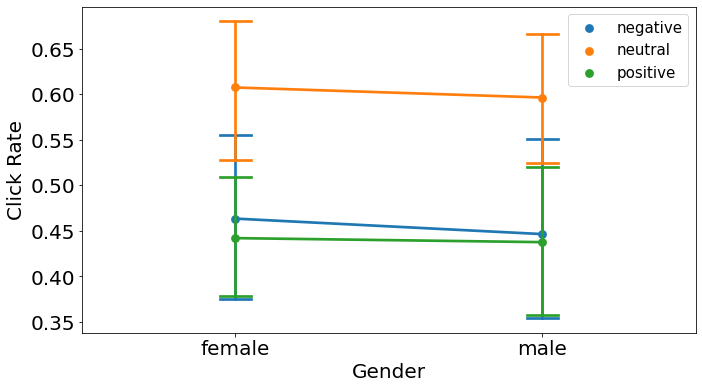

In [37]:
plt.figure(figsize=(11,6))
b = sns.pointplot(data=type_sentiment_gender_clickrate, y='clickrate', x='gender', hue='sentiment', capsize=0.1)
b.set_xlabel("Gender",fontsize=20)
b.set_ylabel("Click Rate",fontsize=20)
b.set_xticklabels(labels=b.get_xticklabels(), fontsize=10)
b.tick_params(labelsize=20)
b.legend(fontsize=15, loc='upper right')

### Question 12 
*The same question as 9 above but replace gender with age-group. (10)*

The code and calculations are identical as above, but instead the groupby object is created on the `age_group` field instead of `gender`:

In [38]:
type_sentiment_agegroup_groupby = log_product_type_df.groupby(['product_type', 'sentiment', 'age_group'])['clickORnot']

type_sentiment_agegroup_clickrate = type_sentiment_agegroup_groupby.sum() / type_sentiment_agegroup_groupby.count()
type_sentiment_agegroup_clickrate.rename('clickrate', inplace=True)

type_sentiment_agegroup_clickrate =  type_sentiment_agegroup_clickrate.reset_index(0).reset_index(0).reset_index(0)
type_sentiment_agegroup_clickrate.to_csv('type_sentiment_agegroup_clickrate.csv')


In [39]:
type_sentiment_agegroup_clickrate

,age_group,sentiment,product_type,clickrate
0,juvenile,negative,blender,0.750000
1,middle-age,negative,blender,0.738462
2,senior,negative,blender,0.672727
3,young,negative,blender,0.803279
4,juvenile,neutral,blender,0.313725
...,...,...,...,...
283,young,neutral,women's purse,0.750000
284,juvenile,positive,women's purse,0.500000
285,middle-age,positive,women's purse,0.358974
286,senior,positive,women's purse,0.583333


In [40]:
type_sentiment_agegroup_clickrate['sentiment_agegroup'] = type_sentiment_agegroup_clickrate['sentiment'] + '_' + type_sentiment_agegroup_clickrate['age_group']

Applying the Tukey HSD, we see that pairwise comparisons by age group and sentiment context are rarely significant, with only 6 comparisons exhibiting a significant difference. This includes:
neutral_juvenile : positive_juvenile 

neutral_middle-age : positive_juvenile 

neutral_senior : positive_juvenile 

neutral_senior : positive_middle-age 

neutral_young : positive_juvenile 

neutral_young : positive_middle-age 

In [41]:
tukey_sentiment_agegroup = pairwise_tukeyhsd(endog=type_sentiment_agegroup_clickrate['clickrate'],
                          groups=type_sentiment_agegroup_clickrate['sentiment_agegroup'], alpha=0.05)

tukey_sentiment_agegroup_anova_df = pd.DataFrame(tukey_sentiment_agegroup.summary())
tukey_sentiment_agegroup_anova_df.columns = tukey_sentiment_agegroup_anova_df.iloc[0]
tukey_sentiment_agegroup_anova_df = tukey_sentiment_agegroup_anova_df[1:]

In [42]:
tukey_sentiment_agegroup.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
negative_juvenile,negative_middle-age,-0.0173,1.0,-0.225,0.1904,False
negative_juvenile,negative_senior,-0.0172,1.0,-0.2249,0.1905,False
negative_juvenile,negative_young,-0.0104,1.0,-0.2181,0.1972,False
negative_juvenile,neutral_juvenile,0.0966,0.9303,-0.1111,0.3043,False
negative_juvenile,neutral_middle-age,0.1069,0.8687,-0.1008,0.3146,False
negative_juvenile,neutral_senior,0.169,0.2406,-0.0387,0.3767,False
negative_juvenile,neutral_young,0.158,0.3397,-0.0497,0.3657,False
negative_juvenile,positive_juvenile,-0.1135,0.8164,-0.3212,0.0942,False
negative_juvenile,positive_middle-age,-0.064,0.9973,-0.2717,0.1437,False
negative_juvenile,positive_senior,0.0183,1.0,-0.1894,0.226,False


The previous analysis is supported by plotting the average clickrates grouped by age group and sentiment context. Again we see that the neutral context performs best across the board, with all significant differences arising from the comparison to click rates of agegroups in the neutral context to other contexts.

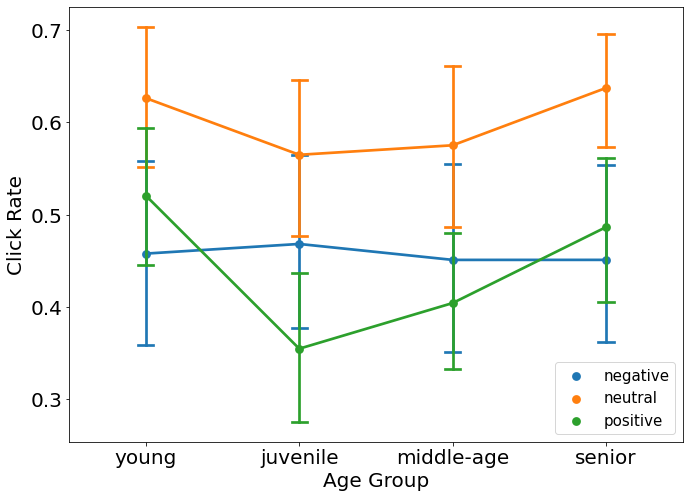

In [43]:
plt.figure(figsize=(11,8))
b = sns.pointplot(data=type_sentiment_agegroup_clickrate, y='clickrate', x='age_group', hue='sentiment', capsize=0.1,
                  order=['young', 'juvenile', 'middle-age', 'senior'])
b.set_xlabel("Age Group",fontsize=20)
b.set_ylabel("Click Rate",fontsize=20)
b.set_xticklabels(labels=b.get_xticklabels(), fontsize=10)
b.tick_params(labelsize=20)
b.legend(fontsize=15, loc='lower right')

### Question 13
*Based on your results make your recommendations. These should be in the form:
a. Based on our analysis (give details of your analysis), ads for such and such product are most likely to produce clicks in such and sentiment context (or state that we see no correlation between click rate of an ad for a product and the sentiment context of the ad)
b. Based on our analysis (with details), ads for such and such product are most likely to produce clicks in such and sentiment context by viewers of such and such gender (or state that we see no correlation between click rate of an ad for a product and the sentiment context of the ad and the gender of the viewer).
c. Based on our analysis (with details), ads for such and such product are most likely to produce clicks in such and sentiment context by viewers of such and such age-group (or state that we see no correlation between click rate of an ad for a product and the sentiment context of the ad and the age-group of the viewer). (15)*


a) Best by sentiment context
Baed on our analysis, ads for products using a neutral sentiment context appear to perform best across the board relative to positive and negative sentiment contexts. This conclusion comes from looking at the average click rate across all products for each sentiment context. We found that average neutral context clickrate was 0.60, and positive = 0.44 and negative = 0.46. This difference was found to be statistically significant by Tukey's HSD. 

Based in individual product performance, we reccomend ads for face cream in the neutral and negative sentiments contexts as they produced of clickrates of 0.93 and 0.90 respectively. On the other hand, we do not recoomend showing ads for pressure cookers in a negative sentiment context, which had the worst performance such that not a single person clicked on these ads.

b) Best by sentiment context and gender
Based on our analysis, when averaging across all products there seems to be no correlation between click rate and sentiment context when controlling for gender. This comes from a pairwise Tukey HSD test which produced no signficant differences between any two groups.

Based on individual product performance, face cream still performs the best when controlling for gender. Specifically, men click on face cream ads in a neutral sentiment context at a rate of 0.94. Interestingly, the 2nd best is pressure cookers in a neutral sentiment context as women click on these ads at a rate of 0.93.

In contrast pressure cookers in a negative sentiment context perform the worst for men and women with a click rate of zero, suggesting that the sentiment context is in fact very important when selling pressure cookers.

c) Best by sentiment context and age group
Based on our analysis, when averaging across all products we see that sentiment context and age group very rarely produce significant differences. Of the 144 possible pairwise comparisons, only 6 were significant by Tukey's HSD. This included neutral_juvenile : positive_juvenile 
neutral_middle-age : positive_juvenile 
neutral_senior : positive_juvenile 
neutral_senior : positive_middle-age 
neutral_young : positive_juvenile 
neutral_young : positive_middle-age 

Taking into account that the large number of error corrections produces a much more rigorous p-value correction (making only the strongest effects visible), we see that the previous conclusion holds where neutral context frequently performs significantly better than other contexts (positive in this case) when controlling for age group.

Based on individual product performance, we see that face cream ads towards young/juvenile users should be prioritized as they have clickrates of 1 and 0.95 respectively in neutral contexts. Additionally pants advertisements in a neutral context should be targeted at middle-aged users as they also have a perfect clickrate. On the other hand pressure cookers should never be advertised in a negative sentiment context as they have a click rate of zero for all age groups. We additionally do not reccomend showing rowing machine ads to juveniles in a neutral sentiment context, or vitamin ads to juveniles in a positive context which additionally had click rates of zero.